<a href="https://colab.research.google.com/github/RaviGprec/NLP/blob/master/stackoverflow_tag_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Stackoverflow Questions and their Tags Prediction**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', 999) 
df = pd.read_csv("QueryResults.csv")
df.head()

,Id,Title,Body,Tags
0,2368896,c# cube / multidimensional dataset,"<p>I'm working on a problem where i need to process multi dimensional data in memory using C#. My requirement resemble OLAP cubes but are not as complex. for example i don't need calculations or aggregation or stuff like that. I basically would like to reference data using multidimensional keys. for example:</p>\n\n<pre><code>var key = new Key();\nkey[""Dim1""] = ""DimValue1"";\nkey[""Dim2""] = ""DimValue2"";\nkey[""Time""] = 1999;\nDataSet[key] = 4.43434m;\n</code></pre>\n\n<p>And it would allow me to iterate on the values or slices of the dataset. Have you come across such a library in C#?</p>\n",<c#><.net><olap><multidimensional-array><cubes>
1,2368898,"How do I use the features of 2.01, yet still support 1.5 with one apk?","<p>I would like my activity to use some features of 2.01, but i need it to be able to run on 1.5 devices. I understand that the 1.5 devices will not be able to run the 2.01 features and thats fine. But i still want them to be able to use the rest of the activity.</p>\n\n<p>I am using Eclipse as my IDE, how do i setup my project correctly? what am i going to have to watch out for? and what the heck does verifyerror mean?</p>\n",<android><eclipse><project>
2,2368900,Can I return a StreamReader from a method?,<p>Can I return a StreamReader from a method ?</p>\n,<.net>
3,2368902,How to Integrate Paypal for month charges that varies?,"<p>I would like to integrate paypal into my current servicing site. I am able to generate the details from database, and retrieve the users' charges, such that a user charges would be using this forumla:</p>\n\n<p><code>Amount payable = no. of hrs service used within the month x $5 per hr</code></p>\n\n<ol>\n<li><p>I would like to charge users based on their usage on per month basis, and automatic billing/deduction from their credit cards. Should I be using a subscribe or buy now settings for my situation?</p></li>\n<li><p>As different users will have different chargeable amount, based on their usage. How should I program/code it in such a way that the payment button for a specify user is set to charge the amount that user is payable for?</p></li>\n</ol>\n\n<p>Thanks in advance.</p>\n",<payment-gateway><paypal>
4,2368903,Spring MVC 3: How do I construct a form action restfully?,"<p>Given some typical search form, I can't construct this form action when submitting a form:</p>\n\n<pre><code>/myapp/orders/${orderId)\n</code></pre>\n\n<p>Because the user is typing in orderId, so I can't include it in the form action.</p>\n\n<ol>\n<li><p>Is there a slick way to do this in\nSpring MVC 3?</p></li>\n<li><p>What about using an Interceptor to construct this? Is\nthat a good solution?</p></li>\n<li><p>Otherwise I'm stuck with using\njavascript to mung with the action\nonSubmit. Fun.</p></li>\n</ol>\n",<java><spring><spring-mvc>


We don't need "Id" so let's remove

In [0]:
df = df[['Title','Body','Tags']]

In [3]:
#check for Missing values
df.isnull().sum()

Title    0
Body     0
Tags     0
dtype: int64

In [4]:
df.duplicated().any()

False

In [5]:
df.shape

(4999, 3)

**Text Preprocessing**

In [0]:
from bs4 import BeautifulSoup
import re
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    #Remove non-alphanumeric and except "#", "." for c# and .net keywords
    stripped_text = re.sub(r'[^A-Za-z0-9#+.\-]+',' ',stripped_text)
    return stripped_text

def Tags_cleaning(text):
  text = text.replace('><'," ")
  text = text.replace('<', "")
  text = text.replace('>', "")
  return text


In [7]:
df['Title'] = df['Title'].apply(lambda text: strip_html_tags(text))
df['Body'] = df['Body'].apply(lambda text: strip_html_tags(text))
df['Tags'] = df['Tags'].apply(lambda text: Tags_cleaning(text))
df.head()

,Title,Body,Tags
0,c# cube multidimensional dataset,I m working on a problem where i need to process multi dimensional data in memory using C#. My requirement resemble OLAP cubes but are not as complex. for example i don t need calculations or aggregation or stuff like that. I basically would like to reference data using multidimensional keys. for example var key new Key key Dim1 DimValue1 key Dim2 DimValue2 key Time 1999 DataSet key 4.43434m And it would allow me to iterate on the values or slices of the dataset. Have you come across such a library in C#,c# .net olap multidimensional-array cubes
1,How do I use the features of 2.01 yet still support 1.5 with one apk,I would like my activity to use some features of 2.01 but i need it to be able to run on 1.5 devices. I understand that the 1.5 devices will not be able to run the 2.01 features and thats fine. But i still want them to be able to use the rest of the activity. I am using Eclipse as my IDE how do i setup my project correctly what am i going to have to watch out for and what the heck does verifyerror mean,android eclipse project
2,Can I return a StreamReader from a method,Can I return a StreamReader from a method,.net
3,How to Integrate Paypal for month charges that varies,I would like to integrate paypal into my current servicing site. I am able to generate the details from database and retrieve the users charges such that a user charges would be using this forumla Amount payable no. of hrs service used within the month x 5 per hr I would like to charge users based on their usage on per month basis and automatic billing deduction from their credit cards. Should I be using a subscribe or buy now settings for my situation As different users will have different chargeable amount based on their usage. How should I program code it in such a way that the payment button for a specify user is set to charge the amount that user is payable for Thanks in advance.,payment-gateway paypal
4,Spring MVC 3 How do I construct a form action restfully,Given some typical search form I can t construct this form action when submitting a form myapp orders orderId Because the user is typing in orderId so I can t include it in the form action. Is there a slick way to do this in Spring MVC 3 What about using an Interceptor to construct this Is that a good solution Otherwise I m stuck with using javascript to mung with the action onSubmit. Fun.,java spring spring-mvc


In [8]:
df['Body'].iloc[3]

'I would like to integrate paypal into my current servicing site. I am able to generate the details from database and retrieve the users charges such that a user charges would be using this forumla Amount payable no. of hrs service used within the month x 5 per hr I would like to charge users based on their usage on per month basis and automatic billing deduction from their credit cards. Should I be using a subscribe or buy now settings for my situation As different users will have different chargeable amount based on their usage. How should I program code it in such a way that the payment button for a specify user is set to charge the amount that user is payable for Thanks in advance. '

**Analysing Tags and their counts**

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(df['Tags']).toarray()
tags = vectorizer.get_feature_names()

In [10]:
tags[:10]

['.bash-profile',
 '.htaccess',
 '.net',
 '.net-1.0',
 '.net-1.1',
 '.net-2.0',
 '.net-3.5',
 '.net-4.0',
 '.net-4.5',
 '.net-client-profile']

In [11]:
print(tag_dtm.shape)
print("No.of Unique tags : ",len(tags))

(4999, 3818)
No.of Unique tags :  3818


In [12]:
tags = pd.DataFrame(tag_dtm,columns =vectorizer.get_feature_names())
tags.head(10)

,.bash-profile,.htaccess,.net,.net-1.0,.net-1.1,.net-2.0,.net-3.5,.net-4.0,.net-4.5,.net-client-profile,.net-core,2d,32-bit,32bit-64bit,3d,3d-model,3ds,absolute,absolute-path,abstract,accelerometer,access,access-vba,access-violation,accessibility,achievements,acl,acrobat,action,action-mapping,actions-on-google,actionscript,actionscript-3,active-directory,activemq,activerecord,activesupport,activex,activity-diagram,activitygroup,...,xpath-2.0,xquery,xquery-3.0,xsd,xslt,xslt-1.0,xslt-2.0,xslt-grouping,yahoo,yajl,yaml,yaml-cpp,yarn,yeoman,yii,yii2,yocto,youtube,youtube-api,youtubeplayer,yum,z-index,z3,zabbix,zappa,zcat,zen-cart,zend-form,zend-framework,zend-framework2,zend-framework3,zend-route,zend-translate,zero,zingchart,zk,zlib,zoom,zul,zynq
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**No.of Times a tag appeared in the data**

In [13]:
freqs = tag_dtm.sum(axis=0)
result = dict(zip(tags, freqs))
result = pd.DataFrame(list(result.items()),columns=['Tag','Count'])
result.head()

,Tag,Count
0,.bash-profile,1
1,.htaccess,14
2,.net,127
3,.net-1.0,1
4,.net-1.1,1


In [0]:
tag_df_sorted = result.sort_values(['Count'], ascending=False)
#tag_counts = tag_df_sorted['Count'].values

**Top 20 tags**

In [15]:
tag_df_sorted.head(20)

,Tag,Count
1727,javascript,473
1716,java,466
491,c#,408
2518,php,374
2672,python,298
107,android,295
1786,jquery,235
1508,html,225
496,c++,198
2191,mysql,178


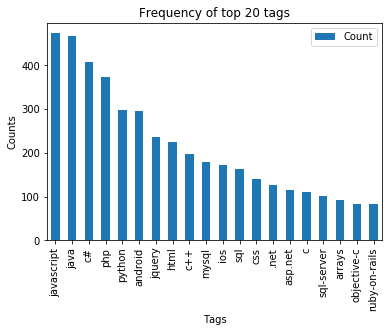

In [16]:
i=np.arange(20)
tag_df_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tag'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

Let's fram Y (target variable) into binary_array

In [0]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary=True)
multilabel_y = vectorizer.fit_transform(df['Tags'])

In [18]:
y_list = vectorizer.get_feature_names()
print(len(y_list))

3818


In [19]:
#print(multilabel_y[0:12].toarray())
total_size=df.shape[0]
train_size=int(0.80*total_size)

x_train=df[['Title','Body']].head(train_size)
x_test=df[['Title','Body']].tail(total_size - train_size)

y_train = multilabel_y[0:train_size,:]
y_test = multilabel_y[train_size:total_size,:]
print("x_train",x_train.shape)
print("x_test",x_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

x_train (3999, 2)
x_test (1000, 2)
y_train (3999, 3818)
y_test (1000, 3818)


In [20]:
x_train.head()

,Title,Body
0,c# cube multidimensional dataset,I m working on a problem where i need to process multi dimensional data in memory using C#. My requirement resemble OLAP cubes but are not as complex. for example i don t need calculations or aggregation or stuff like that. I basically would like to reference data using multidimensional keys. for example var key new Key key Dim1 DimValue1 key Dim2 DimValue2 key Time 1999 DataSet key 4.43434m And it would allow me to iterate on the values or slices of the dataset. Have you come across such a library in C#
1,How do I use the features of 2.01 yet still support 1.5 with one apk,I would like my activity to use some features of 2.01 but i need it to be able to run on 1.5 devices. I understand that the 1.5 devices will not be able to run the 2.01 features and thats fine. But i still want them to be able to use the rest of the activity. I am using Eclipse as my IDE how do i setup my project correctly what am i going to have to watch out for and what the heck does verifyerror mean
2,Can I return a StreamReader from a method,Can I return a StreamReader from a method
3,How to Integrate Paypal for month charges that varies,I would like to integrate paypal into my current servicing site. I am able to generate the details from database and retrieve the users charges such that a user charges would be using this forumla Amount payable no. of hrs service used within the month x 5 per hr I would like to charge users based on their usage on per month basis and automatic billing deduction from their credit cards. Should I be using a subscribe or buy now settings for my situation As different users will have different chargeable amount based on their usage. How should I program code it in such a way that the payment button for a specify user is set to charge the amount that user is payable for Thanks in advance.
4,Spring MVC 3 How do I construct a form action restfully,Given some typical search form I can t construct this form action when submitting a form myapp orders orderId Because the user is typing in orderId so I can t include it in the form action. Is there a slick way to do this in Spring MVC 3 What about using an Interceptor to construct this Is that a good solution Otherwise I m stuck with using javascript to mung with the action onSubmit. Fun.


We'll combine Title and Body to create TF-IDF Matrix

In [21]:
x_train['Text']= x_train['Title'] + " " + x_train['Body']
x_test['Text']= x_test['Title']+" "+ x_test['Body']
print(x_train.shape)
print(x_test.shape)
x_train.head()

(3999, 3)
(1000, 3)


,Title,Body,Text
0,c# cube multidimensional dataset,I m working on a problem where i need to process multi dimensional data in memory using C#. My requirement resemble OLAP cubes but are not as complex. for example i don t need calculations or aggregation or stuff like that. I basically would like to reference data using multidimensional keys. for example var key new Key key Dim1 DimValue1 key Dim2 DimValue2 key Time 1999 DataSet key 4.43434m And it would allow me to iterate on the values or slices of the dataset. Have you come across such a library in C#,c# cube multidimensional dataset I m working on a problem where i need to process multi dimensional data in memory using C#. My requirement resemble OLAP cubes but are not as complex. for example i don t need calculations or aggregation or stuff like that. I basically would like to reference data using multidimensional keys. for example var key new Key key Dim1 DimValue1 key Dim2 DimValue2 key Time 1999 DataSet key 4.43434m And it would allow me to iterate on the values or slices of the dataset. Have you come across such a library in C#
1,How do I use the features of 2.01 yet still support 1.5 with one apk,I would like my activity to use some features of 2.01 but i need it to be able to run on 1.5 devices. I understand that the 1.5 devices will not be able to run the 2.01 features and thats fine. But i still want them to be able to use the rest of the activity. I am using Eclipse as my IDE how do i setup my project correctly what am i going to have to watch out for and what the heck does verifyerror mean,How do I use the features of 2.01 yet still support 1.5 with one apk I would like my activity to use some features of 2.01 but i need it to be able to run on 1.5 devices. I understand that the 1.5 devices will not be able to run the 2.01 features and thats fine. But i still want them to be able to use the rest of the activity. I am using Eclipse as my IDE how do i setup my project correctly what am i going to have to watch out for and what the heck does verifyerror mean
2,Can I return a StreamReader from a method,Can I return a StreamReader from a method,Can I return a StreamReader from a method Can I return a StreamReader from a method
3,How to Integrate Paypal for month charges that varies,I would like to integrate paypal into my current servicing site. I am able to generate the details from database and retrieve the users charges such that a user charges would be using this forumla Amount payable no. of hrs service used within the month x 5 per hr I would like to charge users based on their usage on per month basis and automatic billing deduction from their credit cards. Should I be using a subscribe or buy now settings for my situation As different users will have different chargeable amount based on their usage. How should I program code it in such a way that the payment button for a specify user is set to charge the amount that user is payable for Thanks in advance.,How to Integrate Paypal for month charges that varies I would like to integrate paypal into my current servicing site. I am able to generate the details from database and retrieve the users charges such that a user charges would be using this forumla Amount payable no. of hrs service used within the month x 5 per hr I would like to charge users based on their usage on per month basis and automatic billing deduction from their credit cards. Should I be using a subscribe or buy now settings for my situation As different users will have different chargeable amount based on their usage. How should I program code it in such a way that the payment button for a specify user is set to charge the amount that user is payable for Thanks in advance.
4,Spring MVC 3 How do I construct a form action restfully,Given some typical search form I can t construct this form action when submitting a form myapp orders orderId Because the user is typing in orderId so I can t include it in the form action. Is there a slick way to do 

In [22]:
x_train = x_train['Text']
x_test = x_test['Text']
print(x_train.shape)
print(x_test.shape)

(3999,)
(1000,)


**TF-IDF Matrix creation**

In [0]:
def text_splitter(text):
  return text.split()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = text_splitter, sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train)
x_test_multilabel = vectorizer.transform(x_test)


In [24]:
print("x_train",x_train_multilabel.shape)
print("x_test",x_test_multilabel.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

x_train (3999, 200000)
x_test (1000, 200000)
y_train (3999, 3818)
y_test (1000, 3818)


In [0]:
import pickle

with open("vectorizer.pkl","wb") as f:
   pickle.dump(vectorizer,f)

**Applying Logistic Regression with OneVsRest Classifier**

In [26]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.03
macro f1 score : 0.00896562951920108
micro f1 scoore : 0.25288620120945576
hamming loss : 0.0007118910424305919
Precision recall report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67         2
           2       0.33      0.09      0.14        23
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         1
          14       0.00      0.00 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1

**Save Model**

In [0]:
import pickle

with open("tag_predictor_model.pkl","wb") as f:
   pickle.dump(classifier,f)


**Save all the tags to map the y_predicted values**

In [0]:
import csv
all_Tags = pd.DataFrame(y_list)
all_Tags.to_csv("All_tags.csv")

In [0]:
vectorizer_saved = open("vectorizer.pkl","r")


In [30]:
user_input = ["Facing problem with javascript"]
user_text_x = vectorizer.transform(user_input)
print(user_text_x)

  (0, 193938)	0.5776720043503306
  (0, 193117)	0.1456523283679556
  (0, 128899)	0.4523010769476814
  (0, 128577)	0.24986092359324655
  (0, 87652)	0.33102287324709345
  (0, 59270)	0.5181675083129015


In [31]:
user_text_x.shape

(1, 200000)

In [45]:
f = open("tag_predictor_model.pkl","rb")
model_saved = pickle.load(f)
pred_result = model_saved.predict(user_text_x)
#print(type(pred_result)) now pred_result's type is <class 'scipy.sparse.csr.csr_matrix'>
pred_result = pred_result.toarray() #converted to "<class 'numpy.ndarray'>", we will get an error "tolist() not found" that is why first converted into numpy then into list
print(type(pred_result))
pred_result= pred_result.tolist()
pred_result = pred_result[0]
print(type(pred_result))
print(pred_result[0])

<class 'numpy.ndarray'>
<class 'list'>
0


In [0]:
def vect_to_lable(v):
  l = []
  for i in range(len(v)):
    if v[i] == 1:
      l.append(y_list[i])
  return l


In [43]:
print(vect_to_lable(pred_result))

['javascript']
